<p style="text-align: right"><i>D.Kuster<br>1-Jul-2015</i></p>

Exploring the shapes of stories with python and machine learning APIs
===

A few months ago, a great [video of Kurt Vonnegut](https://www.youtube.com/watch?v=oP3c1h8v2ZQ) circulated the web. He describes an idea for plotting the simple shapes of stories as good vs. ill fortune across the length of the story. He says:

>*"There's no reason why these simple shapes of stories can't be fed into computers*"

by which he probably meant: 
>*"once you have a sequence of numerical scores, it is easy to draw these lines using computers"*

[![Vonnegut: the shapes of stories](http://img.youtube.com/vi/oP3c1h8v2ZQ/0.jpg)](https://www.youtube.com/watch?v=oP3c1h8v2ZQ "Vonnegut: the shapes of stories")
<p style="text-align: center" font color="red"><span style="color:gray">click the image -> video on YouTube.com</span></p>

...but how to get the scores? When I watched the video, I just happened to be developing natural language processing tools for analyzing text. Swimming in that context, it was very natural to wonder: 

### "if we don't have Kurt Vonnegut on hand to interpret stories through his own experience, **how can we plot the shapes of stories directly from the text itself?**"



The problem (of plotting the shapes of stories) is similar to sentiment analysis on the narrator's viewpoint. But it was not clear if existing sentiment models were good enough to pick up on this signal across the length of a long story. Specifically, language is full of subtle contextual cues that can interact with each other. Sentiment models can struggle to balance the interactions amongst many positive vs. negative terms and return stable predictions over long-range context windows. And even once you have the algorithmic bits worked out, validating the result can be tricky when human interpretations differ.

This notebook implements a series of experiments using [indico's](https:www.indico.io) [machine learning API's](https://www.indico.io/models) to quickly test hypotheses. If you simply want to consume the story, keep on scrolling. If you want to tinker, maybe do some experiments of your own...this post was written as a [Jupyter](https://jupyter.org) notebook for exactly that reason. Grab the notebook [here on Github](https://github.com/IndicoDataSolutions/plotlines). And when you discover something interesting, please [let us know](https://twitter.com/indicodata), we love this stuff.

### TL;DR
Using two hacks and a multinomial logistic regression model of n-grams with TF-IDF features, a pre-trained sentiment model can score the long-range sentiment of text of stories, books, and movies. The models do a reasonable job of summarizing the "shapes of stories" directly from text. This method can be easily extended to search across databases to find stories with similar plot shape as the query story.

## CONTENTS
1. Background
1. Define the problem (outcomes, technical requirements)
1. Simple experiment to learn what makes this problem hard
1. Add functionality to satisfy requirements
    * Identify a good use case (+data) for testing against human intepretation
    * Hack: sliding window to sample context
    * Smoothing methods
    * Hack: Dynamic time warping to compare plotlines across stories
1. Compare many stories to find similar plotlines
1. The Disney movie plot formula (or, "How would Vonnegut draw the shapes of Disney stories?")
---

<img src="images/listen-sm.jpg">

#1. Background
If you haven't watched the Vonnegut video yet, "listen and learn" is always a good first step. Few lectures are as short and sweet as this one!

Vonnegut gave us a method to describe the shapes of stories by plotting the protagonist's current fortune (good vs. ill) from the beginning to the end of the story. His method requires a human to read each story and intepret meaning thorugh their own personal context and understanding of stories in general. We're going to automate the scoring method using python and machine learning models for sentiment analysis.

To have any hope of automating a solution, we need clear, specific, solvable technical requirements. Then we'll write code to implement the functionality that satisfies each requirement.

---

<img src="images/Rafiki-thinking-sm.jpg">

#2. Define the problem

The first step to solving a problem is to define it clearly in terms of desired outcomes and technical requirements. Let's do that next. We'll periodically update our progress by incrementing the numbers inside the brackets to indicate percent completion of each requirement.

### To draw the shape of a story, we need an automated method that emits scores as it scans a text from beginning to end. Scores represent the positivity of the narrator. 


### Technical requirements

The method must be:

1. [ 0 ] **Accurate**. Any (human) reader should be able to validate accuracy for stories they have read by simply inspecting and interpreting the text; scores should be high (~1.0) when good stuff is happening, low (~0.0) when bad stuff is happening, and neutral (~0.5) otherwise.
1. [ 0 ] **Sensitive** to rapid (real) changes in fortune. Interesting stories tend to have abrupt changes of fortune, and this should be reflected in the plot line. Note: "sensitivity is used here in the general engineering sense, not in the machine learning definition for recall (
1. [ 0 ] **Interpretable**. Simplicity is what makes Vonnegut's plotlines so compelling. We don't necessarily need such simple shapes, but our plots must enable meaningful conclusions about what is happening across the story.
1. [ 0 ] **Visual** to enable quick evaluation and comparison against Vonnegut's "shapes of stories". 
1. [ 0 ] **Automated**. Requires no human judgment, just input text.
1. [ 0 ] **Easy to use** across a variety of texts. 

#### We can define a few extra "nice to have" features too:
* [ 0 ] **Unequal lengths** can be compared, because it is rare for two texts of interest to have exactly the same length.
* [ 0 ]  **Enables experimentation** so folks can try it on their own texts, build new visualizations, etc.

---

<img src="images/Rafiki-tree-sm.jpg">

#3. Start with a simple experiment (MVP)
We start with a very simple experiment. Then we'll evaluate our technical requirements and prioritize how we want to extend and add features. There are (at least) three good reasons to start with a simple experiment:

* It forces us to get everything connected and working. 
* The process of implementing even the simplest working version will reveal real friction points in our implementation---we'll learn what are the hard and unsolved parts and start developing the intuition for how focused effort will yield results. Testing usually beats assumptions, and profiling hedges against premature optimization.
* It also yields a product to which other people can react. Feedback from multiple sources is less likely to suffer the biases of any given individual.

#### Import modules

In [1]:
import sys
import os
import pandas as pd  # dataframes to store text samples + scores

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn # for more appealing plots

# Pretty printing
import pprint
pp = pprint.PrettyPrinter(indent=4)

# indico API
import indicoio  # https://pypi.python.org/pypi/IndicoIo; install using `pip install -U indicoio`

In [2]:
# Is an indico API key defined?
if not indicoio.config.api_key:
    sys.exit("Unable to find an indico API key, please add one to your python environment. Aborting.")

Note: If this is your first time using an indico API, register for a free API key at [indico.io](http://indico.io). There are several ways to define your key for python; a good option is to add an environment variable to define your personal API key. On Linux or OSX, you can simply add a line to `~/.bash_profile` to define your personal API key. For example: `export INDICO_API_KEY=<your api key>`

#### Simple example input
[Link to full transcription of The Lion King movie, transcribed by fans](http://www.lionking.org/faq.html)

In [3]:
# Sample text from the beginning of `The Lion King` script
input_text = """Rafiki puts the juice and sand he collects on 
                Simba's brow---a ceremonial crown. He then picks 
                Simba up and ascends to the point of Pride Rock. 
                Mufasa and Sarabi follow. With a crescendo in the 
                music and a restatement of the refrain, Rafiki 
                holds Simba up for the crowd to view."""

#### Test ourselves (as human sentiment interpreters) by scoring the input text. 
As a father of young children and older brother who frequently pulled babysitting duty, I've watched The Lion King a gazillion times. So I can say that `input_text` is reservedly positive, and it occurs at the begining of The Lion King movie, when other positive things are happening in the movie (in general). As an English speaker, I don't read anything in the phrase as contradictory or particularly polarizing. The phrase "crescendo in the music" is a cue that something important (positive?) is happening, and life experience suggests the presentation of a new prince is a reservedly positive thing. Polite, modest smiles all around.  If a sentiment score of 0.0 is totally negative, 1.0 is very positive, and 0.5 is neutral, I'd expect a sentiment score for the input text to be: 0.6 < score < 0.9. 

**You should make your own estimate too...do it now, before you see the predictions!**

In [4]:
score = indicoio.batch_sentiment([input_text])  # make an API call to get sentiment score for the input text
print(score)

[0.7735788628299651]


#### Validate the result
Is the score reasonable? Yes, everything agrees with my self-test.

### OK, that was pretty easy! Now that we have a sentiment model connected and working on a toy example, it's time to try something more realistic. 
We only ran a single test (n=1), so we cannot tell the difference between a reproducible method and a happy accident. Let's apply what we learned with this simple experiment to the technical requirements:

### How the indico sentiment analysis API works
The sentiment analysis API abstracts the machine learning process into an API call, so you can use a pre-trained model on any input text. Send a list of strings, get back a list of scores. It is optimized to be fast, robust, and "accurate enough" (90% accuracy on IMDB), so it is well suited to the task at hand, where we want to score many samples across a story. 

Behind the scenes, huge corpora of labeled text data were used to train a multinomial logistic regression model to differentiate between text labeled as positive vs. text labeled as negative. When you send a list of strings to the API, each string is tokenized into n-grams to compute TF-IDF (term frequency-inverse document frequency) features. Then the model uses the pre-trained features to predict the positivity of the input text, and return the score. The models are deployed on robust, load-balanced, distributed architecture, so multiple users can spray multiple requests and reliably get results.

#### Why use an API instead of implementing from scratch (using scikit-learn, etc)?
Because it abstracts away a whole mess of data collection, cleaning, feature engineering, pre-training, regularization, validation, deployment, and performance/scaling. Using the API above, you can use *one line* to get sentiment scores. For cases where you need to tweak things to get the best accuracy possible, or need to train on specific data for a specific purpose or domain, you should probably build your own custom model. But even then, pre-trained models can be great for running quick experiments to explore your data and quickly discover if it is worth investing in a custom model.

## Evaluate requirements:  *simplest experiment*
1. [  5 ] **Accurate**. The score was reasonable for the one-line input text, but this toy example doesn't give us enough to evaluate performance. 
1. [  0 ] **Sensitive**. With only a single score, we have no way to evalute plotlines, let alone sensitivity. We need more than a single score, we need to emit a sequence of scores over the length of the input story.
1. [ 25 ] **Interpretable**. Easy to interpet a single score, but it doesn't help us understand the shape of the story.
1. [ 0 ] **Visual**. Nothing to visualize yet.
1. [ 50 ] **Automated**. All plumbed up and working, but we have to manually specifiy the input text. Need to add the functionality to automatically sample from an input text.
1. [ 100 ] **Easy to use**. Easy one-liner to get sentiment scores.

#### Nice to have
* [   0 ] **Unequal lengths**. Only tested one small snippet from one story. 
* [ 50 ]  **Enables experimentation**. Redefine the input string, test anything you want (manually). Need an automated solution here, ideally something that operates at the granularity of a whole story.

Also, we haven't yet satisfied the main goal: draw the shape of a story using an automated method that emits scores as it scans a text from beginning to end. Technically, we could cut a story into chunks and paste each chunk in as `input_text`.  But that would be silly, the whole point is to automate the method so we can compare to Vonnegut's shapes of stories. Let's add functionality to automatically generate samples from a text, retrieve sentiment scores for each sample, and plot the results for comparison to Vonnegut's shapes of stories.

### Next step: Implement auto-sampling functionality
---

<img src="images/Rafiki-mixing-sm.jpg">

#4. Add functionality: auto-sampling
To extend functionality to scan across the text and emit a sequence of scores, we'll need to upgrade our code to use data structures that can contain sequences (rather than just single values). 

We also need a strategy for generating samples from a chunk of input text.  A naive strategy is to slice the input text at regularly spaced intervals. Although it might seem appealing for the simplicity,  slices introduce discontinuities in the context of the story, and this will cause problems with sentiment analysis. In other words, how should we choose where we make cuts so that we don't destroy information at at the boundary between chunks? Sentiment analysis can be tricky, and we want to make sure we are preserving all the information we can.

One useful solution to eliminate the slice boundaries is to sample from a sliding context window. This will require us to evaluate a greater number of samples, but the sentiment analysis model is fast, so no worries!

### Hack 1: sliding window to sample context

#### Helper functions

In [5]:
def sample_window(seq, window_size = 10, stride = 1):  
    """
    Generator slides a window across the input sequence 
    and returns samples; window size and stride define
    the context window
    """
    for pos in xrange(0, len(seq), stride):
        yield seq[pos : pos + window_size]

In [6]:
def merge(seq, stride = 4):
    """
    Generator strides across the input sequence, 
    combining the elements between each stride.
    """
    for pos in xrange(0, len(seq), stride):
        yield seq[pos : pos + stride] 

#### Core logic/script

In [7]:
d = {}  # dictionary to store results (regardless of story lengths)

# Parse text
delim = " "
words = [s for s in input_text.split()]  # simplest tokenization method

# Merge words into chunks
### Note: this defines the granularity of context for sentiment analysis, 
###  might be worth experimenting with other sampling strategies!
merged_words = [" ".join(w) for w in merge(words, 5)]

# Sample a sliding window of context
delim = " "
samples = [delim.join(s) for s in sample_window(merged_words, 3, 1)] 
pp.pprint(samples)  # comment this line out for big input!
d['samples'] = samples

# Score sentiment using indico API
print("\n  Submitting %i samples..." % (len(samples)))
scores = indicoio.batch_sentiment(samples)
d['scores'] = scores
print("  ...done!")

[   "Rafiki puts the juice and sand he collects on Simba's brow---a ceremonial crown. He then",
    "sand he collects on Simba's brow---a ceremonial crown. He then picks Simba up and ascends",
    'brow---a ceremonial crown. He then picks Simba up and ascends to the point of Pride',
    'picks Simba up and ascends to the point of Pride Rock. Mufasa and Sarabi follow.',
    'to the point of Pride Rock. Mufasa and Sarabi follow. With a crescendo in the',
    'Rock. Mufasa and Sarabi follow. With a crescendo in the music and a restatement of',
    'With a crescendo in the music and a restatement of the refrain, Rafiki holds Simba',
    'music and a restatement of the refrain, Rafiki holds Simba up for the crowd to',
    'the refrain, Rafiki holds Simba up for the crowd to view.',
    'up for the crowd to view.',
    'view.']

  Submitting 11 samples...
  ...done!


#### Visualize the results

,samples,scores
0,Rafiki puts the juice and sand he collects on ...,0.716651
1,sand he collects on Simba's brow---a ceremonia...,0.451806
2,brow---a ceremonial crown. He then picks Simba...,0.211606
3,picks Simba up and ascends to the point of Pri...,0.156922
4,to the point of Pride Rock. Mufasa and Sarabi ...,0.317079
5,Rock. Mufasa and Sarabi follow. With a crescen...,0.561463
6,With a crescendo in the music and a restatemen...,0.913848
7,"music and a restatement of the refrain, Rafiki...",0.949742
8,"the refrain, Rafiki holds Simba up for the cro...",0.934285
9,up for the crowd to view.,0.770297


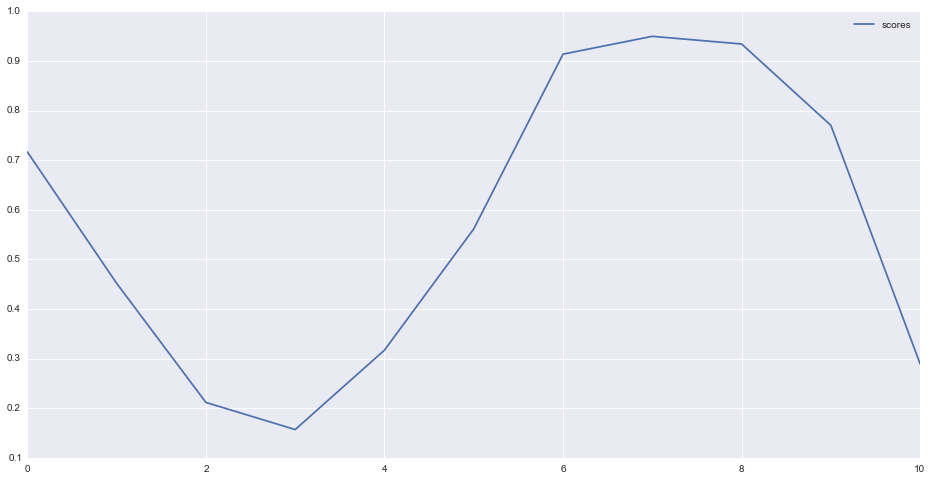

In [8]:
# Load the dict into a dataframe; overkill for now but useful below
df = pd.DataFrame()
for k,v in d.iteritems():  
    df[k] = pd.Series(v)  # keys -> columns, values -> rows
df.plot(figsize = (16,8))
df  # display the table of values

### What just happened?
Check out the visual explanation below!

1. Read some text and split it into words. This defines the granularity of context for sentiment analysis, so if you want to use a different sampling strategy, this would be the place to change it up by splitting on different delimiters. You can also use a fancier tokenizer or lemmatizer instead of the "split on whitespace" strategy here.
2. Merge the list of words into chunks of text. We employ a "split and merge" strategy for two reasons: it works reliably for most any text composed of words, and it gives us independent control over the length and stride when creating samples for sentiment analysis---makes it easy to experiment with different sizes of context windows, different granularities (i.e., chunk sizes), different sampling resolution (i.e., stride).
3. As humans, we tend to interpret context without even thinking about it...but machines need explicit samples across contexts to approximate that kind of behavior. To make sure we're sampling a reasonably stable context, we slide a window over the list of merged words to generate a bunch of overlapping samples.
4. Send the list of samples to the indico API for scoring, get back a list of scores.

<img src="images/preproc.gif">

## Evaluate requirements:  *added sampling via sliding context window*

1. [  5 ] **Accurate**. Unclear, hard to evaluate objectively. Given the small chunks of text being passed in here, the model is probably too sensitive. We need a better test that can be easily validated against human interpretation.
1. [  25 ] **Sensitive**. On the super-simple input, we see plenty of dynamic range, but the response could be driven by either signal or noise. Real signals in sentiment models come from a few strong words, or from many weak words. We fed the model only short phrases and minimal context, so it has no choice but to respond to the few words that are present in the input. Because the sample input didn't happen to contain any particularly strong words, noise has a big impact on the output.
1. [ 100 ] **Interpretable**. Table view + line graph makes this easy enough for a human to scan and evaluate.
1. [ 100 ] **Visual**. It's just a line graph.
1. [ 100 ] **Automated**. All plumbed up and working!
1. [ 100 ] **Easy to use**. Pretty easy so far. But to evaluate more than the simple example, we'll need to abstract some things. We'll be careful to balance flexibility vs. usability.

#### Nice to have
* [   0 ] **Unequal lengths**. Only tested one sample.
* [ 100 ]  **Enables experimentation**. Redefine the input string, test anything you want.

Importantly, we satisfied the main goal of drawing the shape of a story using a fully-automated method that emits scores as it scans a text from beginning to end. We can compare these to Vonnegut's shapes of stories! Now let's  improve the accuracy. We'll do it by finding more robust data, making our tests more rigorous, and validating the results in an experiment where human interpretation is relatively easy and transparent. 

### Next step: better data --> better tests
---

<img src="images/rafiki2-sm.jpg">

#5. Assemble a corpus of data to validate subjective (human) interpretation
Now that we have a pipeline for drawing the shapes of stories, we need a better test. The first step is to find data.

To validate Vonnegut's hypothesis, I initially wanted to score the same stories he described. But I've only read Hamlet once, and that was more than enough. Vonnegut's stories may be archetypal fiction plots, but for me it was very hard to validate performance when I couldn't remember the context and sequence of events from those stories. Wait a second...he mentioned the Cinderella story, everyone knows that one, right?

I searched the web for a canonical version of Cinderella, but quickly discovered that the myth has dozens of variations. Having been exposed to many versions since childhood, it was impossible to attribute my interpretation of the Cinderella story to any single context or version. Turns out academics hypothesize how each version of Cinderella reflects the culture from whence it came...what a mess! This is the opposite of a good test for validating the performance of our plotlines. We want authoritative versions.

<img src="images/rafiki-holdon-sm.jpg">

Finally, thinking *"what is the most popular version of cinderella?"*...I definitely remember watching Disney's version of Cinderella!  Were movies scripts a better test than written stories?

It turns out that movies have a number of useful constraints for the task at hand. Written stories are typically consumed in many sittings, many contexts, over many hours, but movies are: 

* time-boxed and consumed all in a single sitting/context
* sequences of events are more memorable when they occur on-screen as audio-visual media vs. written as text (for me, at least)
* have similar lengths
* every movie has a script, either the original or transcriptions produced by fans

Unfortunately, I couldn't find a good script of Disney's 1950 version of Cinderella freely available on the web.  However, fans have transcribed many other movies, including The Lion King, Aladdin, The Little Mermaid, Sleeping Beauty, and more:

* [The web's largest movie script resource](http://www.imsdb.com)
* [Top Google hit for "Disney Movie Scripts"](http://www.fpx.de/fp/Disney/Scripts/)

---


<img src="images/rafiki-eating-sm.jpg">

### Extend code to iterate over each story in a corpus
Now that we have multiple texts, we need to abstract the simple code above to iterate across a corpus of text files. Dataframes are a good data structure for storing and manipulating the result here. We'll also need to add some cleaning/munging code since movie scripts from the internet can be messy.

In [9]:
# define your corpus here as a list of text files
corpus = ["aladdin.txt",
          "lionking.txt",
          "mulan.txt",
          "hunchback.txt",
          "rescuersdownunder.txt",
          "sleepingbeauty.txt",
          "littlemermaid.txt"]

In [10]:
# New dict to hold data
d = {}

# Map names to input files on filesystem
root_fp = os.getcwd()
corpus_fp = os.path.join(root_fp, "texts")   # put your text files in ./texts
print("Looking for input text files: '%s'" % corpus_fp)

for t in corpus:
    fp = os.path.join(corpus_fp, t)
    print(" Reading '%s'" % t)
    with open(fp, 'rb') as f:
        text_name = t.split(".")[0]  # strip .txt file extensions
        sample_col = text_name + "_sample"
        score_col = text_name + "_sentiment"
        lines = []  # list to receive cleaned lines of text
        
        # Quick text cleaning and transformations
        for line in f:
            if str(line) == str(""): # there are many blank lines in movie scripts, ignore them
                continue
            else:
                line = line.replace("\n", " ").lower().strip().strip('*')  # chain any other text transformations here
                lines.append(line)
        print("  %i lines read from '%s' with size: %5.2f kb" % (len(lines), t, sys.getsizeof(lines)/1024.))
        
        # Construct a big string of clean text
        text = " ".join(line for line in lines)
        
        # split on sentences (period + space)
        delim = ". "
        sentences = [_ + delim for _ in text.split(delim)]  # regexes are the more robust (but less readable) way to do this...
        merged_sentences = [delim.join(s) for s in merge(sentences, 10)]  # merge sentences into chunks
        
        # split on words (whitespace)
        delim = " "
        words = [_ for _ in text.split()]
        merged_words = [" ".join(w) for w in merge(words, 120)]  # merge words into chunks
        
        # Generate samples by sliding context window
        delim = " "
        samples = [delim.join(s) for s in sample_window(merged_words, 10, 1)]
        d[sample_col] = samples
        
        print("   submitting %i samples for '%s'" % (len(samples), fp))
        
        # API to get scores
        scores = indicoio.batch_sentiment(samples)
        d[score_col] = scores
        
print("\n...complete!")

Looking for input text files: '/Users/djk/Documents/INDICO/DEMOS/Movie_plotlines/texts'
 Reading 'aladdin.txt'
  2639 lines read from 'aladdin.txt' with size: 23.18 kb
   submitting 143 samples for '/Users/djk/Documents/INDICO/DEMOS/Movie_plotlines/texts/aladdin.txt'
 Reading 'lionking.txt'
  3506 lines read from 'lionking.txt' with size: 29.42 kb
   submitting 135 samples for '/Users/djk/Documents/INDICO/DEMOS/Movie_plotlines/texts/lionking.txt'
 Reading 'mulan.txt'
  1231 lines read from 'mulan.txt' with size:  9.97 kb
   submitting 78 samples for '/Users/djk/Documents/INDICO/DEMOS/Movie_plotlines/texts/mulan.txt'
 Reading 'hunchback.txt'
  2659 lines read from 'hunchback.txt' with size: 23.18 kb
   submitting 106 samples for '/Users/djk/Documents/INDICO/DEMOS/Movie_plotlines/texts/hunchback.txt'
 Reading 'rescuersdownunder.txt'
  882 lines read from 'rescuersdownunder.txt' with size:  7.80 kb
   submitting 82 samples for '/Users/djk/Documents/INDICO/DEMOS/Movie_plotlines/texts/rescu

In [11]:
df = pd.DataFrame()
for k,v in d.iteritems():
    df[k] = pd.Series(v)  # keys -> columns, rows -> columns

In [12]:
df = pd.DataFrame()
for k,v in d.iteritems():
    df[k] = pd.Series(v)  # keys -> columns, rows -> columns

In [13]:
df.head(5)  # inspect the first 5 rows...looks OK?

,hunchback_sample,lionking_sample,mulan_sample,rescuersdownunder_sample,rescuersdownunder_sentiment,hunchback_sentiment,lionking_sentiment,sleepingbeauty_sample,littlemermaid_sample,littlemermaid_sentiment,aladdin_sample,mulan_sentiment,aladdin_sentiment,sleepingbeauty_sentiment
0,disney's the hunchback of notre dame (as the w...,"the lion king {open, black screen} {start natu...",mulan the complete script a chinese painting o...,the rescuers down under opening: the camera sl...,0.812134,0.699814,0.421786,walt disney's sleeping beauty [the book opens ...,the little mermaid an ocean. birds are flying ...,0.971097,aladdin: the complete script peddler: oh i com...,0.935301,0.540695,0.932075
1,"of sounds, so many changing moods. because, yo...",ms: siyo nqoba [we're going to conquer] bs: in...,the hun leader; other signals go on all the wa...,the crocodile falls area and some of the surro...,0.893503,0.319084,0.724241,wishes too. we pledge our loyalty anew. hail t...,"merpeople, lad. thought every good sailor knew...",0.842828,"dunes. ah, salaam and good evening to you wort...",0.837544,0.555306,0.886473
2,"docks near notre dame gypsy 1: shut it up, wil...",the sun there's more to see than can ever be s...,"up reserves, and as many new recruits as possi...","[cody slides through a log, picks up a stick, ...",0.954304,0.386786,0.834280,these monarchs dreamed one day their kingdoms ...,triton: i'm really looking forward to this per...,0.834772,"peddler hurries to catch it.) wait, don't go! ...",0.792785,0.523802,0.813945
3,"stolen goods, no doubt. take them from her. cl...",despair and hope through faith and love {appea...,smart boy! can you help me with my chores toda...,of animals and the forest.] [they arrive at th...,0.922784,0.426293,0.799421,walk with springtime wherever she goes fauna: ...,"song sebastian wrote, her voice is like a bell...",0.740849,sand from the lamp into his hand.) it begins o...,0.773323,0.499568,0.785493
4,to it. he is about to drop the baby down the w...,for the crowd to view.} fs: it's the circle of...,the doctor said three cups of tea in the morni...,cuts two ropes. cody cuts the last rope to fre...,0.874259,0.214561,0.811837,merryweather: you weren't wanted! maleficent: ...,"with something. yeah, i got this cough. [floun...",0.709885,get what's coming to you. iago: what's coming ...,0.849055,0.443469,0.751146


In [14]:
# inspect the last 5 rows; 
# since sequences are of unequal length, there should be a bunch of NaN's 
# at the end for all but the longest sequence

df.tail(5)

,hunchback_sample,lionking_sample,mulan_sample,rescuersdownunder_sample,rescuersdownunder_sentiment,hunchback_sentiment,lionking_sentiment,sleepingbeauty_sample,littlemermaid_sample,littlemermaid_sentiment,aladdin_sample,mulan_sentiment,aladdin_sentiment,sleepingbeauty_sentiment
101,"outside, he sees nothing but gargoyles (includ...",all its living things can you feel the love to...,NaN,NaN,NaN,0.858617,0.641429,NaN,NaN,NaN,i never knew but when i'm way up here it's cry...,NaN,0.465241,NaN
102,"(he swings his cape, covering quasi's head. bu...",out on my own. live my own life. and i did. an...,NaN,NaN,NaN,0.888111,0.545838,NaN,NaN,NaN,you dare close your eyes jasmine: an hundred t...,NaN,0.137337,NaN
103,quasimodo! quasi! (he slips loose and begins t...,doesn't matter. hakuna matata. nala: {confused...,NaN,NaN,NaN,0.976008,0.441713,NaN,NaN,NaN,time to spare let me share this whole new worl...,NaN,0.121282,NaN
104,"his face. they then hug, and quasi picks her u...",again} nala: good. at least one of us does. {s...,NaN,NaN,NaN,0.769387,0.446861,NaN,NaN,NaN,abu had to miss this. aladdin: nah. he hates f...,NaN,0.077000,NaN
105,over them. birds have once again covered laver...,it's my fault. it's my fault. {he bows his hea...,NaN,NaN,NaN,0.783339,0.343603,NaN,NaN,NaN,the pressures of palace life. (carpet slumps d...,NaN,0.151034,NaN


### Results! 
Let's look at The Lion King since many people are familiar with the story/movie and will therefore be able to validate the results.

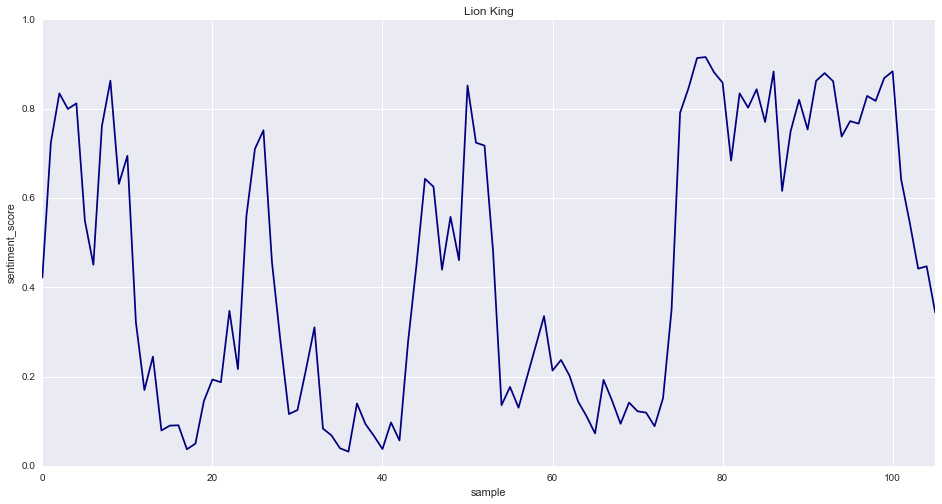

In [15]:
ax = df['lionking_sentiment'].plot(colormap = 'jet', figsize=(16,8))
ax.set_xlabel("sample")
ax.set_ylabel("sentiment_score")
ax.set_title("Lion King")

<img src="images/lionking-details.jpg">
<img src="images/kv-sm.jpg">

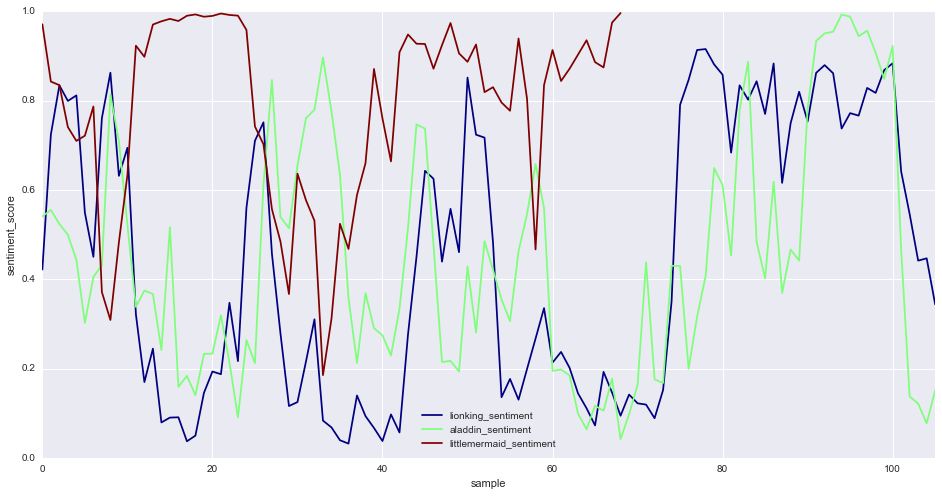

In [16]:
# Pick out a few stories to compare visually
combo = pd.DataFrame()
combo['lionking_sentiment'] = df['lionking_sentiment']
combo['aladdin_sentiment'] = df['aladdin_sentiment']
combo['littlemermaid_sentiment'] = df['littlemermaid_sentiment']
ax2 = combo.plot(colormap='jet', figsize = (16,8))  # ignore mistmatched sequence length
ax2.set_xlabel("sample")
ax2.set_ylabel("sentiment_score")

**Looks like The Lion King and Aladdin have very similar plot lines**, from the sequencing (song, then something happens) to the big hump of hero happiness followed by the valley of gloom. Are we detecting some kind of Disney formula for movies/stories? It's hard to compare these visually when the plotlines are happening across different lengths. 

Note: the downturn to neutral at the very end of the story is probably due to the neutral "outro" and credits that appear at the end of movie scripts.

## Evaluate progress
1. [  100 ] **Accurate**. Bigger/better test data and resampling with a sliding window seems to have helped quite a lot! Feel free to tweak parameters (chunk size, window width, stride) to see how it affects sentiment scores. The values above seem to work reasonably well for movie scripts and fiction novels. Accuracy is rarely perfect, but for the task of validating plotlines of stories, at least in my own personal assessment, we're getting a more objective and informative result than Vonnegut's plotlines, so call the accuracy requirement satisfied.
1. [  65 ] **Sensitive**. The sliding window helped a lot here too, where we can see the sentiment change quickly between positive and negative. But the plots are probably too complex and noisy compared to Vonnegut's simple shapes of stories...then again, Vonnegut's shapes might be too smooth, sacrificing relevant details in an attempt at generality. Too bad we can't ask him to do an apples-to-apples comparison here!
1. [ 90 ] **Interpretable**. We lost some power to interpret the plotlines when we started comparing stories. We need a way to map stories of different lengths into some common space where comparisons are more meaningful.
1. [ 100 ] **Visual**. 
1. [ 100 ] **Automated**.
1. [  100 ] **Easy to use**. 

#### Nice to have
* [  10 ] **Unequal lengths**. We're handling sequences of different lengths using dictionaries and dataframes with NaN values, but this doesn't help us visually compare stories. Let's fix that.
* [ 100 ]  **Enables experimentation**. Redefine the input string, test anything you want.

### Next steps: Explore smoothing methods
---

<img src="images/rafiki-almost-sm.jpg">

## Smoothing kernels
Smoothing kernels are an obvious thing to try for filtering out some high-frequency noise, and several reasonable methods are available within pandas. For unequal length sequences, for now we'll simply ignore the NaN's and plot as much sequence as avaialable for each story. 

In [17]:
# Pull out a single story here to test smoothing methods
df_sentiment = df["lionking_sentiment"].dropna()

(0, 110)

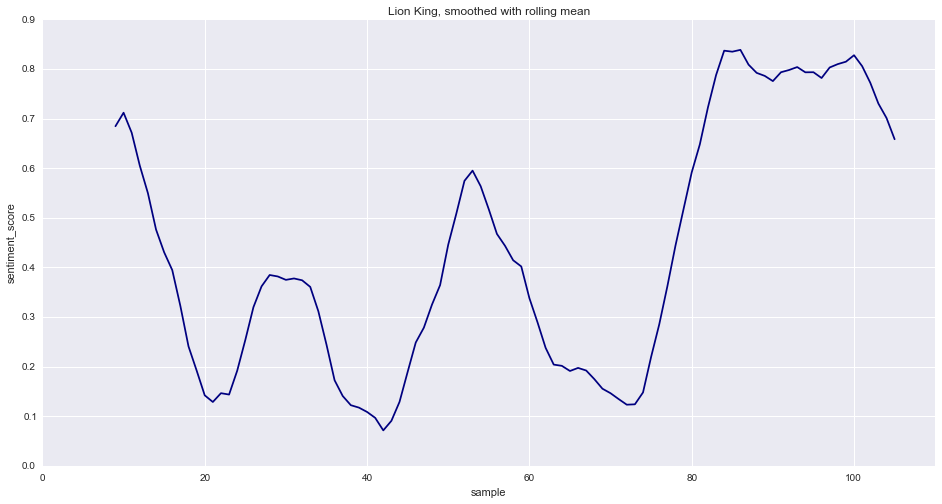

In [18]:
df_roll = pd.rolling_mean(df_sentiment, 10)
ax = df_roll.plot(colormap = 'jet', figsize = (16, 8))
ax.set_xlabel("sample")
ax.set_ylabel("sentiment_score")
ax.set_title("Lion King, smoothed with rolling mean")
ax.set_xlim((0, 110))

### Alternative smoothing method: Lowess
The moving average smoothing isn't bad, and we're getting pretty close to Vonnegut's simple shapes!  But since we used a sliding window to resample the text for sentiment analysis, another sliding window method is probably not the best choice here, as it could falsely convey a stronger confidence or stability of prediction than is justified by scores. We've also traded sensitivity for smoothness. Sentiment tends to be sensitive to the balance of positive vs. negative weights, so noise is probably a useful quantity to track, especially since we don't yet know how it varies across stories. Also, the bigger kernels take a while to accumulate samples, eating into the beginning of a story where interesting stuff can happen. Another method might be a better choice---one that doesn't consume data to build up statistical moments. Let's give Lowess smoothing a try and compare to the raw scores.

(0, 110)

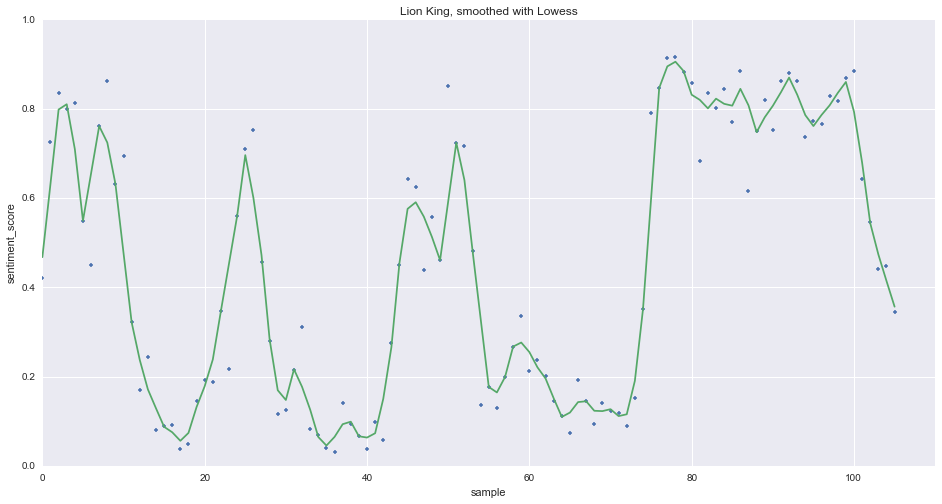

In [19]:
import scipy.stats as stats
import statsmodels.api as sm

lowess = sm.nonparametric.lowess(df_sentiment, df_sentiment.index, frac = 0.05)
fig = plt.gcf()
plt.plot(df_sentiment.index, df_sentiment, '.')  # plot the values as dots
plt.plot(lowess[:, 0], lowess[:, 1])       # plot the smoothed output as solid line
fig.set_size_inches(16,8)
plt.xlabel('sample')
plt.ylabel('sentiment_score')
plt.title('Lion King, smoothed with Lowess')
plt.xlim((0, 110))

## Evaluate progress: *smoothing*
1. [ 100 ] **Accurate**. 
1. [ 100 ] **Sensitive**. There's usually a tradeoff of sensitivity vs. noise when evaluating smoothing methods, and that seems true here. Lowess smoothing gives a better balance of sensitivity vs. visual simplicity to compare against Vonnegut's shapes of stories. The moving window methods sacrifice too much and obfuscate the beginnings of stories. We'll use Lowess.
1. [ 100 ] **Interpretable**. 
1. [ 100 ] **Visual**. 
1. [ 100 ] **Automated**.
1. [ 100 ] **Easy to use**. 

#### Nice to have
* [  10 ] **Unequal lengths**. Ignoring or truncating NaN's is not particuarly helpful, and interpolation would cause data transparency issues (e.g., "was this data point interpolated, or a real score?"). We need a better way to compare stories and score similarity. Time to find a suitable distance metric.
* [ 100 ]  **Enables experimentation**. 

### Next steps: distance metric & solve the problem of comparing unequal lengths
---

<img src="images/rafiki-brucelee-sm.jpg">

## Distance metric
### Hack 2: Dynamic Time Warping
The method of dynamic time warping is great for comparing sequences that have arbitrary insertions between otherwise similar data. It can also solve our problem of comparing sequences of unequal lengths. Intuitively, DTW seems like a good fit for our problem. Let's test it.

<img src="images/dtw-md.png">

<p style="text-align: center" font color="gray"><span style"color:gray">Image from: Rakthanmanon et al. "Searching and Mining Trillions of Time Series Subsequences under Dynamic Time Warping", Figure 3.</span></p>

### How it works
Read the linked papers for details, but the gist is dynamic time warping gives us a way to map one sequence onto another sequence, using dynamic programming and distance measures between elements in each sequence.  The best mapping from one sequence to another is the path that minimizes the pairwise distances.  Lower distances indicate sequences with high similarity.

#### Interpreting the path graph
If we put one sequence (e.g., "lionking_sentiment") on the x-axis and another sequence (e.g., "aladdin_sentiment") on the y-axis, then the diagonal path from lower-left to upper right illustrates the transformation that best maps the x sequence onto the y sequence. For two identical sequences, the path would be a perfect diagonal.  For difference sequences, the path reveals where each sequence is "warped" to accommodate the other sequence.

For the knowledge hounds, here's a [link to the original paper that introduced DTW](http://www.aaai.org/Papers/Workshops/1994/WS-94-03/WS94-03-031.pdf) and [Rakthanmanon et al.](http://www.cs.ucr.edu/~eamonn/SIGKDD_trillion.pdf)

In [20]:
import dtw

lionking = df['lionking_sentiment'].dropna()
aladdin = df['aladdin_sentiment'].dropna()
print(len(lionking), len(aladdin))

dist, cost, path = dtw.dtw(lionking, aladdin)  # compute the best DTW mapping
print("Minimum distance found: %-8.4f" % dist)

(106, 106)
Minimum distance found: 0.0622  


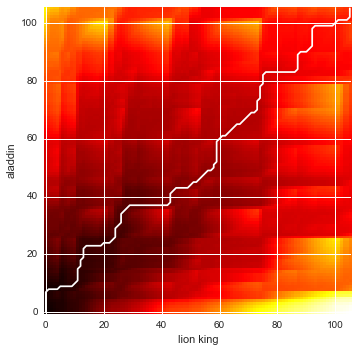

In [21]:
from matplotlib import cm  # custom colormaps
from matplotlib.pyplot import imshow
imshow(cost.T, origin = 'lower', cmap = cm.hot, interpolation = 'nearest')
plt.plot(path[0], path[1], 'w')  # white line shows the best path
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))
plt.xlabel("lion king")
plt.ylabel("aladdin")

**The Lion King and Aladdin have very similar plots!** Hardly any warping is required to map one story sequence onto the other.

What about another pair of stories?

In [22]:
mermaid = df['littlemermaid_sentiment'].dropna()
print(len(lionking), len(mermaid))

dist, cost, path = dtw.dtw(lionking, mermaid)
print("Minimum distance found: %-8.4f" % dist)

(106, 69)
Minimum distance found: 0.0916  


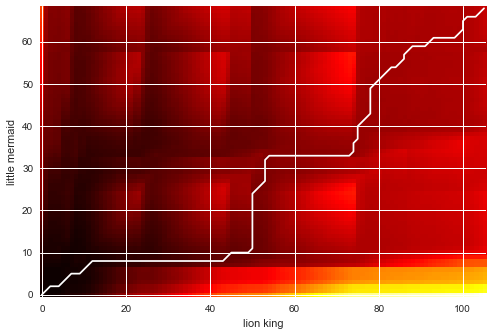

In [23]:
from matplotlib import cm  # import custom colormaps
from matplotlib.pyplot import imshow
imshow(cost.T, origin = 'lower', cmap = cm.hot, interpolation = 'nearest')
plt.plot(path[0], path[1], 'w')  # white line for the best path
plt.xlim((-0.5, cost.shape[0]-0.5))
plt.ylim((-0.5, cost.shape[1]-0.5))
plt.xlabel("lion king")
plt.ylabel("little mermaid")

**The Lion King and The Little Mermaid appear to have similar plotlines, but there are gaps where things happen in Lion King but no corresponding features in Little Mermaid** This different story pacing could be because The Lion King's characters are thoroughly anthropomorphized and speak many lines throughout the movie whereas the characters in The Little Mermaid tend tell the story through action and visuals---the protagnoist loses her voice! Or it could be a difference in transcript length or quality showing through...something to investigate more deeply. We can see from the DTW path that the plotlines are different for the first part of the movie, but the last 30% is very similar.

# 5. Compare many stories to find similar plotlines
### Since we have a distance metric, can we find plotlines based on a query story?
Using the DTW distance metric, it is straightward to compare all the pairs of stories in our corpus. Using these distances to sort (or search) for similar (or different) stories is left as an exercise for the reader :) There is probably a neat visualization to be made here, but beyond scope for now!

In [24]:
for i in corpus:
    for j in corpus:    
        (dist, cost, path) = dtw.dtw(df[i.split(".")[0] + "_sentiment"].dropna(), 
                                     df[j.split(".")[0]   + "_sentiment"].dropna())
        print("DTW distance from %s to %s: '%-6.3f'" % (i.split(".")[0], j.split(".")[0], dist))

DTW distance from aladdin to aladdin: '0.000 '
DTW distance from aladdin to lionking: '0.062 '
DTW distance from aladdin to mulan: '0.094 '
DTW distance from aladdin to hunchback: '0.074 '
DTW distance from aladdin to rescuersdownunder: '0.084 '
DTW distance from aladdin to sleepingbeauty: '0.084 '
DTW distance from aladdin to littlemermaid: '0.093 '
DTW distance from lionking to aladdin: '0.062 '
DTW distance from lionking to lionking: '0.000 '
DTW distance from lionking to mulan: '0.075 '
DTW distance from lionking to hunchback: '0.071 '
DTW distance from lionking to rescuersdownunder: '0.061 '
DTW distance from lionking to sleepingbeauty: '0.060 '
DTW distance from lionking to littlemermaid: '0.092 '
DTW distance from mulan to aladdin: '0.094 '
DTW distance from mulan to lionking: '0.075 '
DTW distance from mulan to mulan: '0.000 '
DTW distance from mulan to hunchback: '0.086 '
DTW distance from mulan to rescuersdownunder: '0.034 '
DTW distance from mulan to sleepingbeauty: '0.060 '

## Evaluate progress: *distance metric and solving unequal lengths problem*
1. [ 100 ] **Accurate**. 
1. [ 100 ] **Sensitive**. 
1. [ 100 ] **Interpretable**. 
1. [ 100 ] **Visual**. 
1. [ 100 ] **Automated**.
1. [ 100 ] **Easy to use**. 

#### Nice to have
* [ 100 ] **Unequal lengths**. Dynamic time warping gives us a distance metric for evaluating the similarity between stories, regardless of length.
* [ 100 ]  **Enables experimentation**. 

### Next step: Summary & ideas for new features!
---

<img src="images/rafiki-happyending-sm.jpg">

#6. The Disney movie script formula, by the plotlines
### Or, "How would Vonnegut draw the shape of a Disney movie script?"

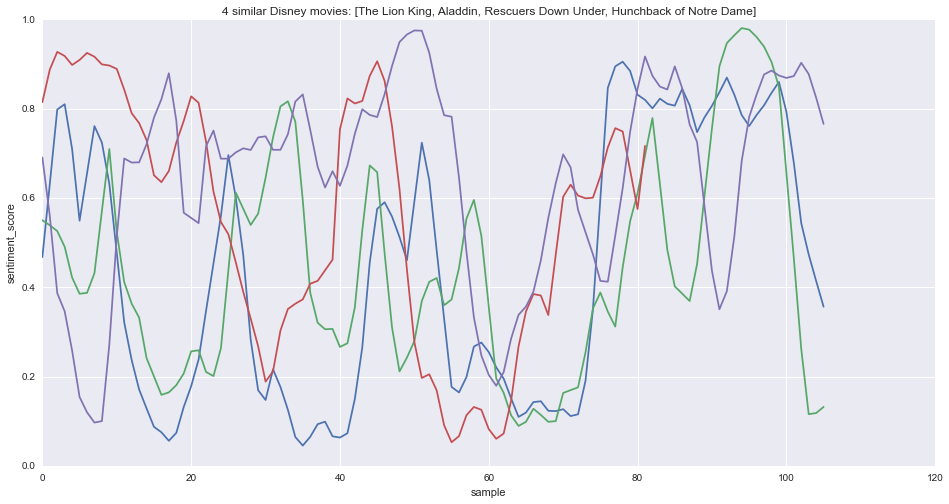

In [25]:
lowess_frac = 0.05  # same smoothing as above, balances detail and smoothness
lionking_lowess = sm.nonparametric.lowess(df['lionking_sentiment'], df['lionking_sentiment'].index, frac = lowess_frac)
aladdin_lowess = sm.nonparametric.lowess(df['aladdin_sentiment'], df['aladdin_sentiment'].index, frac = lowess_frac)
rescuers_lowess = sm.nonparametric.lowess(df['rescuersdownunder_sentiment'], df['rescuersdownunder_sentiment'].index, frac = lowess_frac)
hunchback_lowess = sm.nonparametric.lowess(df['hunchback_sentiment'], df['hunchback_sentiment'].index, frac = lowess_frac)

fig = plt.gcf()
plt.plot()
plt.plot(lionking_lowess[:, 0], lionking_lowess[:, 1])
plt.plot(aladdin_lowess[:, 0], aladdin_lowess[:, 1])
plt.plot(rescuers_lowess[:, 0], rescuers_lowess[:, 1])
plt.plot(hunchback_lowess[:, 0], hunchback_lowess[:, 1])
plt.xlabel('sample')
plt.ylabel('sentiment_score')
plt.title('4 similar Disney movies: [The Lion King, Aladdin, Rescuers Down Under, Hunchback of Notre Dame]')
fig.set_size_inches(16,8)



### What if we dial up the smoothing to compare vs. Vonnegut's shapes of stories?

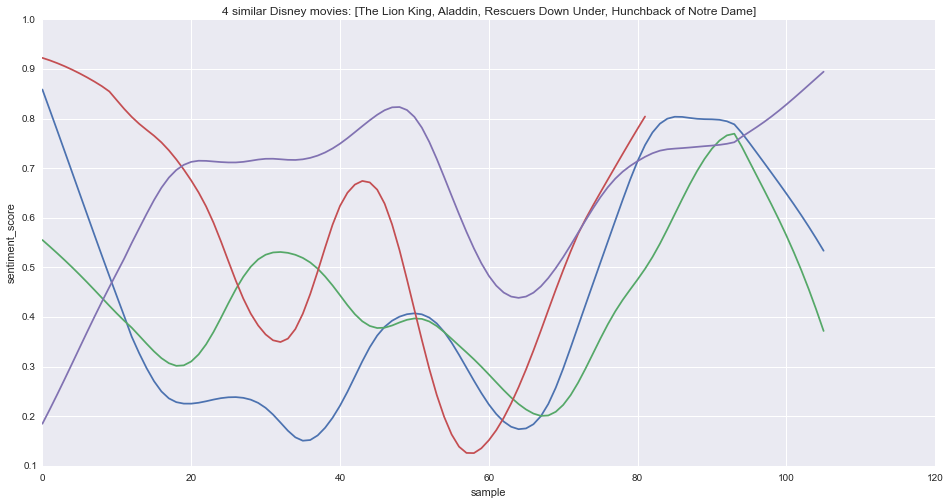

In [26]:
lowess_frac = 0.25  # heavy smoothing here to compare to Vonnegut
lionking_lowess = sm.nonparametric.lowess(df['lionking_sentiment'], df['lionking_sentiment'].index, frac = lowess_frac)
aladdin_lowess = sm.nonparametric.lowess(df['aladdin_sentiment'], df['aladdin_sentiment'].index, frac = lowess_frac)
rescuers_lowess = sm.nonparametric.lowess(df['rescuersdownunder_sentiment'], df['rescuersdownunder_sentiment'].index, frac = lowess_frac)
hunchback_lowess = sm.nonparametric.lowess(df['hunchback_sentiment'], df['hunchback_sentiment'].index, frac = lowess_frac)

fig = plt.gcf()
plt.plot()
plt.plot(lionking_lowess[:, 0], lionking_lowess[:, 1])
plt.plot(aladdin_lowess[:, 0], aladdin_lowess[:, 1])
plt.plot(rescuers_lowess[:, 0], rescuers_lowess[:, 1])
plt.plot(hunchback_lowess[:, 0], hunchback_lowess[:, 1])
plt.xlabel('sample')
plt.ylabel('sentiment_score')
plt.title('4 similar Disney movies: [The Lion King, Aladdin, Rescuers Down Under, Hunchback of Notre Dame]')
fig.set_size_inches(16,8)


### Beginnings vary, but the last 30% of a Disney movie is quite predictable!
When we compare many Disney movie scripts, a clear pattern emerges. Maybe this isn't intuitively surprising to you, but the fact we **discovered "the Disney formula" directly from the text of a movie script** is pretty cool!

Disney introduces characters and sets the scene in a variety of ways, but every story ends in similar fashion: 

* In the middle of the story, there comes a big hump of positivity where the hero finds friends, achieves happiness, discovers new skills or powers. 
* Then a big drop into negativity, where the hero experiences loss, tragedy, and difficulties. Usually instigated by the villain!
* At about 75% of the story, the hero decides to climb out of the valley of tragedy. This is often catalyzed by an accessory character or friend of the hero. Good things happen again! 
* The world is happy, and the story ends with a few minutes of general positivity (and a song).

# Thank you for reading!
This was fun to discover and write, and I hope you have enjoyed reading about it. If the stuff here ends up being helpful, forked, or incorporated into a cool project, please let us know! We love hearing about innovative applications!

### Ideas for future features:
Parallel exploration by a diverse bunch of investigators is a great way to discover cool stuff! It would be great if folks try these and share any discoveries:

* Search a database for plotlines. The input query could be the name of an existing story, a user-uploaded text, or even a hand-drawn plotline shape. There's no reason DTW couldn't be used to compare distances between an arbitrarily drawn plotline and all the stories in a database. Just requires a big database of stories.
* The same parameters used here seem to work reasonably well for English fiction in general: novels, closed captioning, speeches, etc. I looked at many stories (via [Project Gutenberg](https://www.gutenberg.org) and other corpora), and there were clearly good plotlines to be investigated. The longer written texts are just slower to validate.
* It might be possible to get a reasonable "story" by plotting the sequence of posts-over-time from blogs, social media, etc. I would expect the underlying shapes to be different than for fiction stories, and time would be continuously dragging out the endpoints there...but could be very interesting.
* There are many movie scripts and stories available online. It would be cool to discover patterns in other genres (Sci-fi vs. Westerns?), authors, cultures, etc. Best way to do this is parallel exploration by a bunch of investigators!